#Bosy Ayman, 202202076

In [59]:
!unzip /content/data.zip

Archive:  /content/data.zip
replace data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Imports

In [60]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import zipfile
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [61]:
import matplotlib.pyplot as plt


In [62]:
extract_dir = 'data'
path = '/content/data.zip'
if not os.path.isdir(extract_dir):
    with zipfile.ZipFile(path)as z:
        z.extractall(path)
    print(os.listdir(extract_dir))
    files = os.listdir(extract_dir)


# Plot Pitch For a Chicken Record (0.25)

[Text(0.5, 1.0, 'log Power spectrogram')]

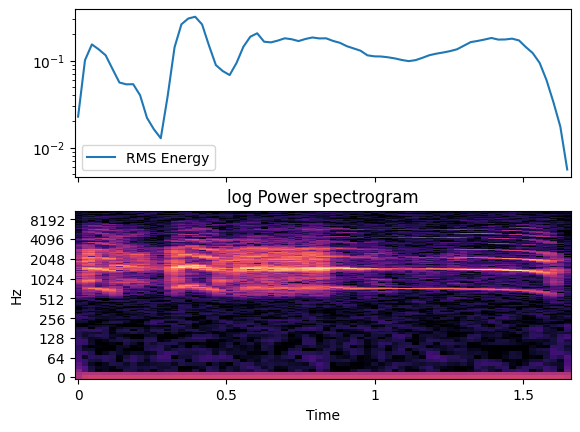

In [63]:
files = os.listdir('/content/data/Chicken')


file_path = os.path.join('data/Chicken',files[0])
waveform,sample_rate = librosa.load(file_path)
librosa.feature.rms(y=waveform)
S, phase = librosa.magphase(librosa.stft(waveform))
rms = librosa.feature.rms(S=S)
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

# Plot Pitch For a Dog Record (0.25)

[Text(0.5, 1.0, 'log Power spectrogram')]

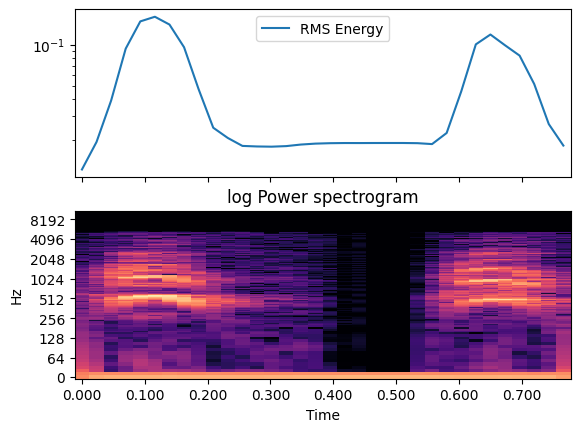

In [64]:
files = os.listdir('/content/data/Dog')


file_path = os.path.join('data/Dog',files[0])
waveform,sample_rate = librosa.load(file_path)
librosa.feature.rms(y=waveform)
S, phase = librosa.magphase(librosa.stft(waveform))
rms = librosa.feature.rms(S=S)
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                                        y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')

# Load Data (0.5)

In [74]:
def extract_mfcc(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

    # Always return fixed length vector (20,)
    return np.mean(mfcc, axis=1)


In [66]:
import os
import numpy as np
import librosa

def load_dataset(base_dir):
    """
    Loads all audio files from class subfolders inside the dataset directory,
    extracts MFCC features, and assigns numerical labels to each class.

    Args:
        base_dir (str): Path to the dataset folder containing class subfolders.

    Returns:
        tuple: Features (X), labels (y) as NumPy arrays, and class names.
    """
    X, y = [], []

    classes = sorted(os.listdir(base_dir))  # sorted for consistent label order

    for label_idx, cls in enumerate(classes):
        cls_path = os.path.join(base_dir, cls)

        # Skip non-directory items
        if not os.path.isdir(cls_path):
            continue

        for fname in os.listdir(cls_path):
            if fname.lower().endswith(".wav"):

                file_path = os.path.join(cls_path, fname)

                try:
                    # Extract MFCC features
                    features = extract_mfcc(file_path)
                    X.append(features)
                    y.append(label_idx)

                except Exception as e:
                    print(f"[Warning] Failed to process {file_path}: {e}")

    return np.array(X), np.array(y), classes


# Train (3)


In [69]:
def split_dataset(X, y, test_size=0.3, random_state=42):
    """
    Splits the dataset into training and testing sets.

    Args:
        X (np.ndarray): Feature matrix.
        y (np.ndarray): Label array.
        test_size (float): Proportion of the dataset used for testing (default=0.3).
        random_state (int): Random seed for reproducibility (default=42).

    Returns:
        tuple: X_train, X_test, y_train, y_test arrays.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

In [70]:
def train_gmms(X_train, y_train, n_components=4):
    gmms = []
    for cls in np.unique(y_train):
        gmm = GaussianMixture(n_components=n_components, covariance_type='diag')
        gmm.fit(X_train[y_train == cls])
        gmms.append(gmm)
    return gmms


# Evaluation (1)

In [79]:
def predict_gmms(gmms, X_test):
    """
    Predicts class labels for test samples based on the highest GMM likelihood.

    Args:
        gmms (list): List of trained GMM models.
        X_test (np.ndarray): Test feature matrix.

    Returns:
        list: Predicted class labels.
    """
    y_pred = []
    for sample in X_test:
        scores = [gmm.score(sample.reshape(1, -1)) for gmm in gmms]

        y_pred.append(np.argmax(scores))
    return y_pred

In [91]:
def evaluate_model(y_test, y_pred, classes):
    """
    Prints the classification report and confusion matrix for model evaluation.

    Args:
        y_test (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        classes (list): Class names corresponding to label indices.
    """
    print("Classes:", classes)
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Run

In [92]:
# Load dataset and extract features
base_dir = '/content/data'
X, y, classes = load_dataset(base_dir)

# Split into train and test
X_train, X_test, y_train, y_test = split_dataset(X, y)

# Train GMM models for each class
gmms = train_gmms(X_train, y_train)

# Predict test data
y_pred = predict_gmms(gmms, X_test)

# Evaluate results
evaluate_model(y_test, y_pred, classes)

Classes: ['.DS_Store', 'Chicken', 'Dog']
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.27      0.21      0.24        19
           2       0.00      0.00      0.00        14

    accuracy                           0.12        33
   macro avg       0.09      0.07      0.08        33
weighted avg       0.15      0.12      0.14        33

Confusion Matrix:
 [[ 0  0  0]
 [15  4  0]
 [ 3 11  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_